# Deep Neural Network with Tensorflow (All IBD)

This pipeline has now been optimised for production deployment.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import shap

from sklearn.model_selection import (
    GroupShuffleSplit,
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import datetime
from tensorflow.keras.metrics import AUC


from utils.data import load_and_preprocess_data
from utils.constants import NUMERICAL_FEATURES, RANDOM_SEED
from utils.plots import (
    plot_training_validation_auc,
    plot_training_validation_loss,
    plot_roc_curve,
)

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pipeline Configuration

In [2]:
random_seed = RANDOM_SEED  # Random seed to ensure reproducibility
output_path = "output/dnn/"
cmap = "seismic"  # Colormap for SHAP plots use "seismic" for full cohort and "berlin" for biochem remission cohort
file_prefix = "tensorflow"
# file_prefix = "biochem_remission"

## Data Loading

In [3]:
df = load_and_preprocess_data() # pass biochem=True to use only biochem remission cohort

# Optimisation for production
# We removed low value features here and simplified the model

columns_to_drop = [
    "has_active_symptoms",
    "baseline_eims_arthralgia_arthritis",
    "baseline_eims_ankylosing_spondylitis",
    "baseline_eims_erythema_nodosum",
    "baseline_eims_uveitis",
    "baseline_eims_scleritis_episclerities",
    "is_smoker_smokeryn1",
    "study_group_name_Await Dx",
    "ifx_drug_level",
    "ada_drug_level",
    "ifx_drug_level_present",
    "ada_drug_level_present",
    "ifx_antibody_present",
    "ada_antibody_present",
    "haematocrit",
]

df.drop(columns=columns_to_drop, inplace=True)

numerical_features = NUMERICAL_FEATURES
numerical_features = [col for col in numerical_features if col not in ['haematocrit', 'ada_drug_level', 'ifx_drug_level']]

In [4]:
# Create Train Validate and Test Datasets

# First split into train and temp 70% train, 30% temp which will be split 50:50 into 15% val and 15% test

# GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=0.36, n_splits=1, random_state=random_seed)

# Perform the split
for train_idx, test_idx in splitter.split(df, groups=df["study_id"]):
    train_data = df.iloc[train_idx]
    temp_data = df.iloc[test_idx]

# Drop 'study_id' from X_train and X_test as it's not a feature
X_train = train_data.drop(columns=["fatigue_outcome", "study_id"])
y_train = train_data["fatigue_outcome"]

groups = train_data["study_id"]  # Group variable for GroupKFold cross-validation

temp_data_splitter = GroupShuffleSplit(
    test_size=0.56, n_splits=1, random_state=random_seed
)

# Perform the split
for val_idx, test_idx in temp_data_splitter.split(
    temp_data, groups=temp_data["study_id"]
):
    val_data = df.iloc[val_idx]
    test_data = df.iloc[test_idx]

X_val = val_data.drop(columns=["fatigue_outcome", "study_id"])
y_val = val_data["fatigue_outcome"]

X_test = test_data.drop(columns=["fatigue_outcome", "study_id"])
y_test = test_data["fatigue_outcome"]


print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)
print("Y train shape:", y_train.shape)
print("Y val shape:", y_val.shape)
print("Y test shape:", y_test.shape)

Train shape: (768, 64)
Val shape: (186, 64)
Test shape: (261, 64)
Y train shape: (768,)
Y val shape: (186,)
Y test shape: (261,)


## Create Train and Test Datasets

GroupShuffleSplit used to ensure same participant only appears in either train or test set.

In [5]:
X_unified = pd.concat([X_train, X_val, X_test])
unified_scaler = StandardScaler()
unified_scaler.fit(X_unified[numerical_features])

X_train[numerical_features] = unified_scaler.transform(X_train[numerical_features])
X_test[numerical_features] = unified_scaler.transform(X_test[numerical_features])
X_val[numerical_features] = unified_scaler.transform(X_val[numerical_features])

## Deep Learning with TensorFlow


### Model Definition

In [6]:
model = keras.Sequential(
    [
        layers.Dense(320, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(320, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid"),
    ]
)

# log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

### Compiling the Model

In [7]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=[AUC()])

In [8]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_callback],
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.6215 - loss: 0.6739 - val_auc: 0.7159 - val_loss: 0.6033
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7869 - loss: 0.5553 - val_auc: 0.7418 - val_loss: 0.5787
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8100 - loss: 0.5308 - val_auc: 0.7640 - val_loss: 0.5697
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8382 - loss: 0.5048 - val_auc: 0.7710 - val_loss: 0.5642
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8181 - loss: 0.5157 - val_auc: 0.7934 - val_loss: 0.5423
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8600 - loss: 0.4774 - val_auc: 0.7954 - val_loss: 0.5423
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8782 - loss: 0.4468 - val_auc: 0.7991 - val_loss: 0.5543
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8779 - loss: 0.4441 - val_auc: 0.8090 - val_loss: 0.5292
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8926 - loss: 

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32, 320)              │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 320)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 320)              │       102,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 320)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 1)                │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,684 (967.52 KB)

 Trainable params: 123,841 (483.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 123,843 (483.77 KB)

In [10]:
history_dict = history.history
history_dict.keys()

dict_keys(['auc', 'loss', 'val_auc', 'val_loss'])

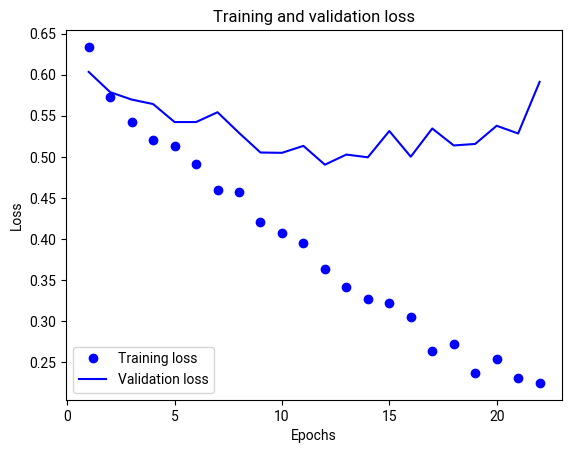

In [11]:
plot_training_validation_loss(history_dict, output_path, file_prefix)

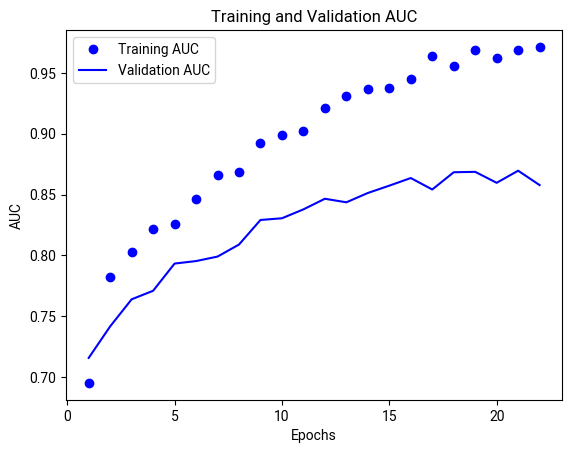

In [12]:
plot_training_validation_auc(history_dict, output_path, file_prefix)

In [13]:
results = model.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8335 - loss: 0.5102 


In [14]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score

y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred)

y_classes = np.where(y_pred > 0.5, 1, 0)

tn, fp, fn, tp = confusion_matrix(y_test, y_classes).ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_classes)
sensitivity = recall_score(y_test, y_classes)  # TPR
specificity = tn / (tn + fp)  # TN

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("AUC:", test_auc)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.8045977011494253
Sensitivity: 0.7524752475247525
Specificity: 0.8375
AUC: 0.859591584158416


In [15]:
np.savetxt(output_path + "dnn_fpr.txt", fpr)
np.savetxt(output_path + "dnn_tpr.txt", tpr)

with open(output_path + "dnn_auc.txt", "w") as f:
    f.write(str(test_auc))

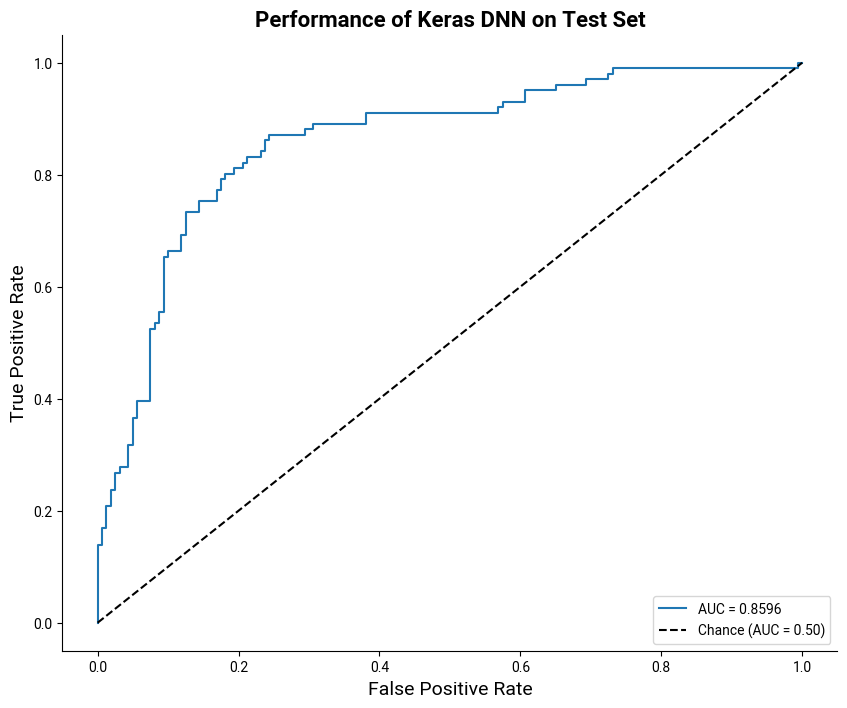

In [16]:
plot_roc_curve(fpr, tpr, test_auc, output_path, file_prefix)

## SHAP Analysis on Keras DNN Model

In [17]:
X_test_clean_columns = [
    col.replace("montreal_cd_location_", " ") for col in X_test.columns
]
X_test_clean_columns = [col.replace("_", " ") for col in X_test_clean_columns]
X_test_clean_columns = [
    col.replace("montreal uc extent ", "") for col in X_test_clean_columns
]
X_test_clean_columns = [
    col.replace("montreal cd behaviour ", "") for col in X_test_clean_columns
]
X_test_clean_columns = [col.replace("name ", "") for col in X_test_clean_columns]
# to title case
X_test_clean_columns = [col.title() for col in X_test_clean_columns]
X_test_clean_columns = [col.replace("Uc", "UC") for col in X_test_clean_columns]
X_test_clean_columns = [col.replace("Bmi", "BMI") for col in X_test_clean_columns]
X_test_clean_columns = [col.replace("Crp", "CRP") for col in X_test_clean_columns]
print(X_test_clean_columns)

['Age', 'Sex', 'Height', 'Weight', 'BMI', 'Age At Diagnosis', 'Montreal Upper Gi', 'Montreal Perianal', 'Albumin', 'CRP', 'Haemoglobin', 'Red Cell Count', 'White Cell Count', 'Neutrophils', 'Lymphocytes', 'Monocytes', 'Eosinophils', 'Basophils', 'Platelets', 'Urea', 'Creatinine', 'Sodium', 'Potassium', 'Calprotectin', 'Sampling Steroids', 'Sampling Abx', 'Sampling Asa', 'Sampling Aza', 'Sampling Mp', 'Sampling Ifx', 'Sampling Ada', 'Sampling Vedo', 'Sampling Uste', 'Sampling Tofa', 'Sampling Mtx', 'Sampling Ciclosporin', 'Sampling Filgo', 'Sampling Upa', 'Sampling Risa', 'Disease Duration Weeks', 'Diagnosis Year', 'Study Group Cd', 'Study Group Ibdu', 'Study Group UC', ' L1 Ileal', ' L2 Colonic', ' L3 Ileocolonic', 'B1 Non-Stricturing, Non-Penetrating', 'B2 Stricturing', 'B3 Penetrating', 'E1 Proctitis', 'E2 Left-Sided', 'E3 Extensive', 'Montreal UC Severity S0 Remission', 'Montreal UC Severity S1 Mild', 'Montreal UC Severity S2 Moderate', 'Montreal UC Severity S3 Severe', 'Is Smoker E

In [18]:
explainer = shap.KernelExplainer(model, shap.sample(X_train, 200))
shap_values = explainer.shap_values(X_test)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 261/261 [04:05<00:00,  1.06it/s]


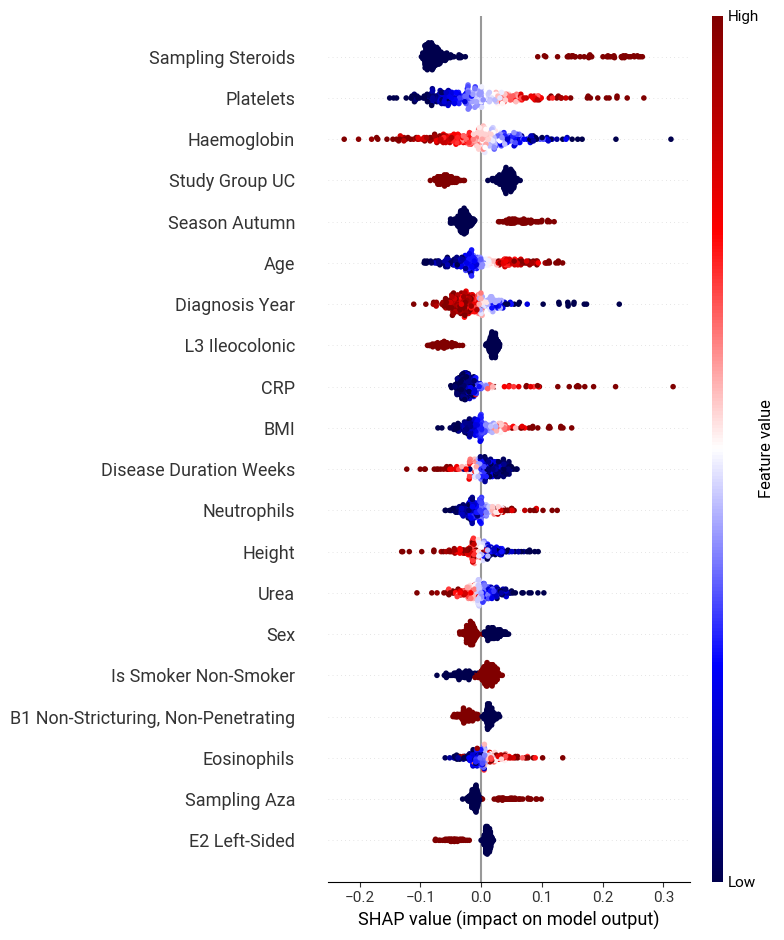

In [19]:
shap_values_class_1 = shap_values[:, :, 0]
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test_clean_columns,
    show=False,
    cmap=cmap,
)

# plt.title("Keras DNN Classifier", fontsize=20, pad=20, loc="left")

save_path = f"{output_path}shap_keras_dnn.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

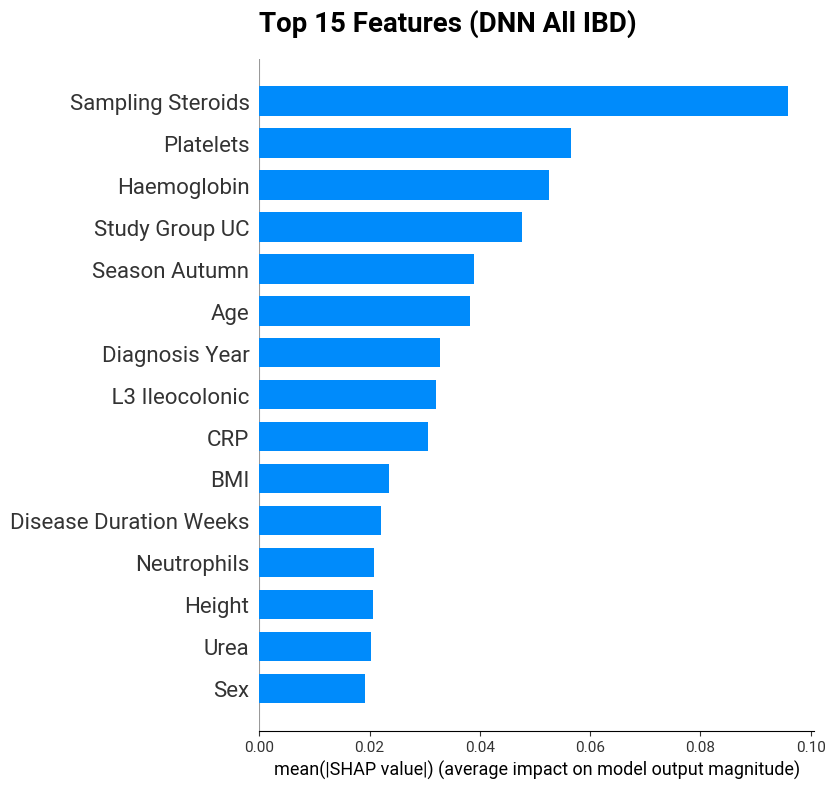

In [20]:
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test_clean_columns,
    show=False,
    cmap=cmap,
    plot_type="bar",
    max_display=15,
)


plt.title(
    "Top 15 Features (DNN All IBD)", fontsize=20, pad=20, loc="left", fontweight="bold"
)
plt.yticks(fontsize=16)

save_path = f"{output_path}shap_keras_dnn_barplot.png"
plt.savefig(save_path, dpi=600, bbox_inches="tight")
plt.show()

In [21]:
shap.initjs()

In [22]:
X_test_reverted = X_test

In [23]:
X_test_reverted[numerical_features] = unified_scaler.inverse_transform(
    X_test[numerical_features]
)

In [24]:
X_test_reverted[numerical_features] = X_test_reverted[numerical_features].round(2)

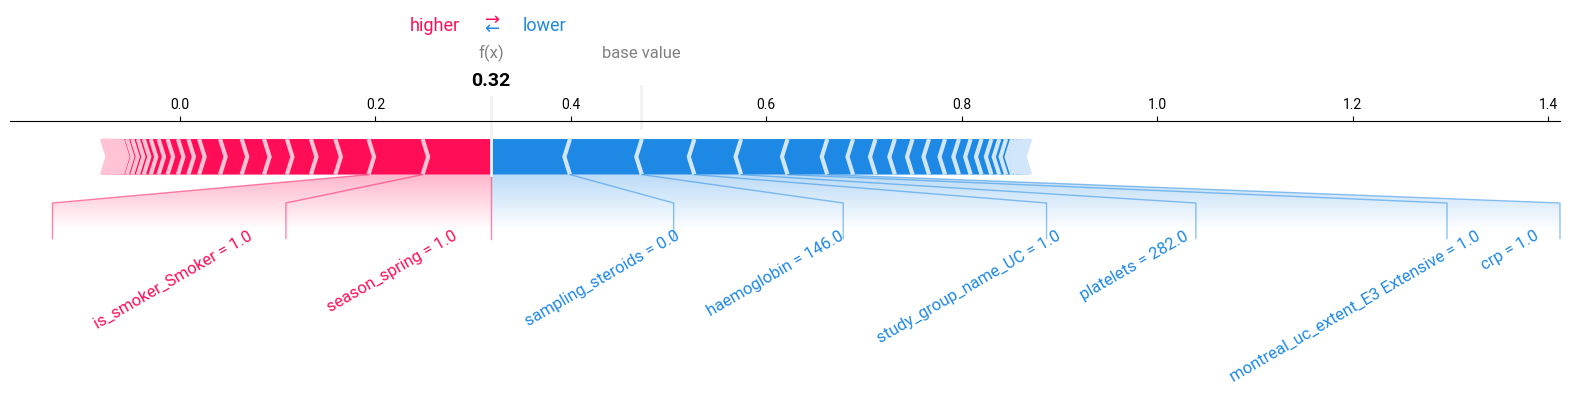

In [25]:
for i in range(1):
    shap.force_plot(
        explainer.expected_value[0],
        shap_values_class_1[i],
        X_test_reverted.iloc[i],
        matplotlib=True,
        contribution_threshold=0.05,
        text_rotation=30,
        show=False,
    )

    save_path = f"{output_path}forceplot_{i}.png"
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

In [26]:
# Find incorrect predictions

outcomes = pd.concat([y_test, pd.Series(y_classes.ravel(), index=y_test.index)], axis=1)
outcomes.columns = ["true", "predicted"]

incorrect_predictions = outcomes[outcomes["true"] != outcomes["predicted"]]
incorrect_predictions = incorrect_predictions.join(X_test_reverted)
incorrect_predictions.to_csv(
    f"{output_path}forceplots_incorrect_predictions.csv",
    index=False,
)
shap_values_incorrect_predictions = pd.DataFrame(
    shap_values_class_1, index=y_test.index
)
shap_values_incorrect_predictions = shap_values_incorrect_predictions.loc[
    incorrect_predictions.index
]
shap_values_incorrect_predictions = shap_values_incorrect_predictions.to_numpy()
X_test_reverted_incorrect_predictions = X_test_reverted.loc[incorrect_predictions.index]
X_test_reverted_incorrect_predictions.reset_index(inplace=True)
X_test_reverted_incorrect_predictions.drop(columns=["index"], inplace=True)

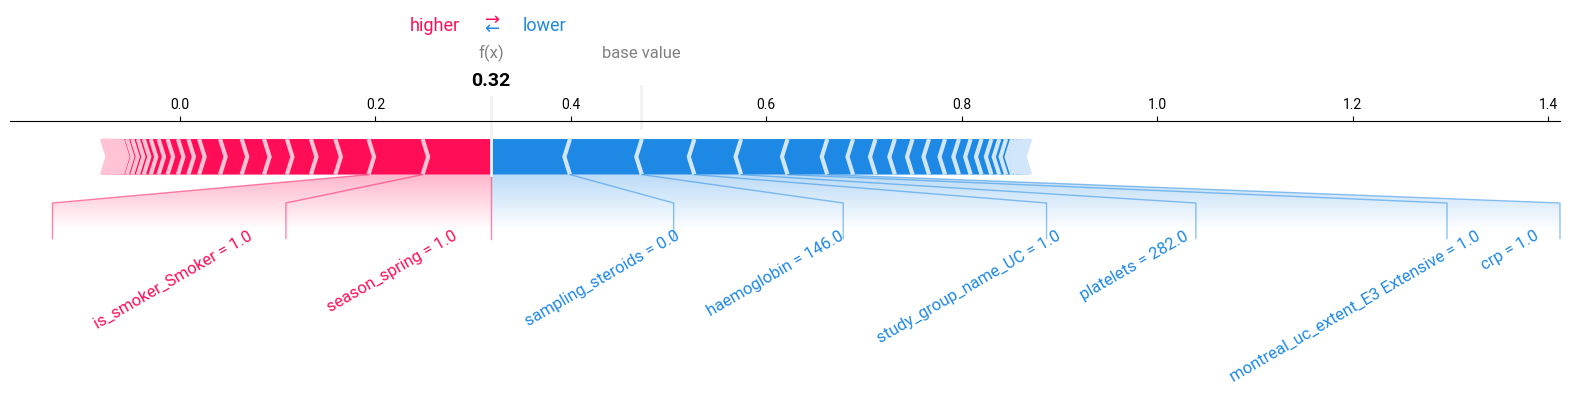

In [27]:
number_of_incorrect_predictions = 1 # len(shap_values_incorrect_predictions) # Uncomment to run all incorrect predictions

for i in range(number_of_incorrect_predictions):
    shap.force_plot(
        explainer.expected_value[0],
        shap_values_incorrect_predictions[i],
        X_test_reverted_incorrect_predictions.iloc[i],
        matplotlib=True,
        contribution_threshold=0.05,
        text_rotation=30,
        show=False,
    )

    save_path = (
        f"{output_path}forceplot_incorrect_{i}.png"
    )
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

## Production Exports

In [28]:
import pickle
from joblib import dump

dump(unified_scaler, output_path + "export/scaler.pkl")
X_train.to_csv(output_path + "export/X_train.csv", index=False)
X_test.to_csv(output_path + "export/X_test.csv", index=False)
model.save(f"{output_path}export/fatigue_model.keras")
with open(output_path + "export/shap_explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)

## Model Validation with Mini-MUSIC dataset

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


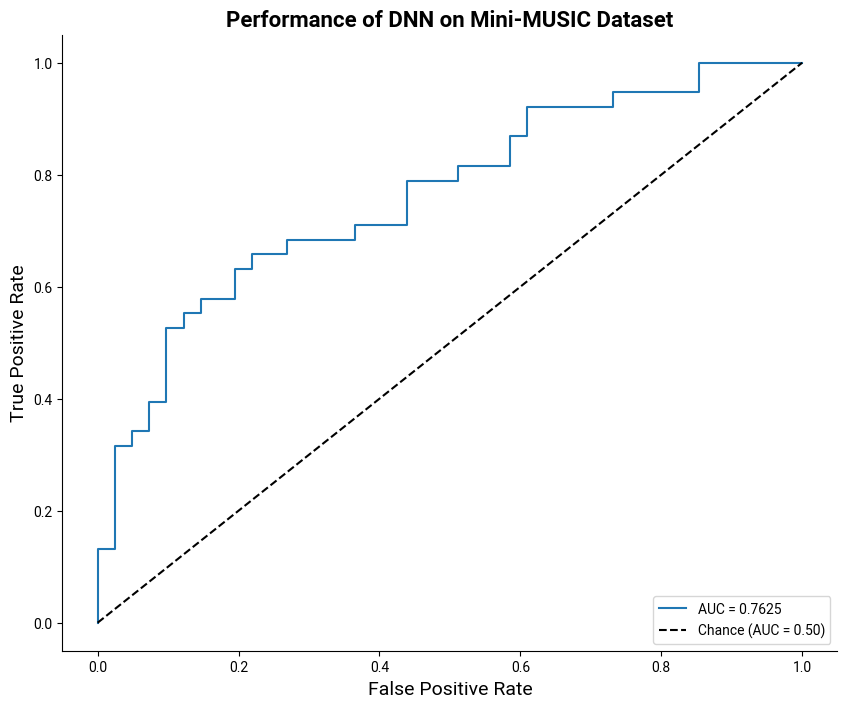

In [38]:
validation_df = pd.read_csv("data/minimusic_cleaned_validation.csv")

X_mini_music = validation_df.drop(columns=["fatigue_outcome"])
y_mini_music = validation_df["fatigue_outcome"]

# scale the numerical features

X_mini_music[numerical_features] = unified_scaler.transform(X_mini_music[numerical_features])

# predict the fatigue outcome
y_pred_mini_music = model.predict(X_mini_music)

# calculate the AUC
auc_mini_music = roc_auc_score(y_mini_music, y_pred_mini_music)
fpr, tpr, thresholds = roc_curve(y_mini_music, y_pred_mini_music)

# plot the auc curve

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"AUC = {auc_mini_music:.4f}")
plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Performance of DNN on Mini-MUSIC Dataset", fontsize=16, fontweight="bold")
plt.legend(loc="lower right")
# Remove the top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# Define the absolute path and save the plot
save_path = f"{output_path}mini_music_roc_curves.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()


In [32]:
print(len(y_mini_music))

79


In [42]:
y_classes_mini_music = np.where(y_pred_mini_music > 0.5, 1, 0)

tn, fp, fn, tp = confusion_matrix(y_mini_music, y_classes_mini_music).ravel()

# Print the confusion matrix
print("Confusion Matrix:")
print("TN:", tn)
print("FP:", fp)
print("FN:", fn)
print("TP:", tp)

# Calculate metrics
accuracy = accuracy_score(y_mini_music, y_classes_mini_music)
sensitivity = recall_score(y_mini_music, y_classes_mini_music)  # TPR
specificity = tn / (tn + fp)  # TN

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("AUC:", auc_mini_music)

Confusion Matrix:
TN: 34
FP: 7
FN: 16
TP: 22
Accuracy: 0.7088607594936709
Sensitivity: 0.5789473684210527
Specificity: 0.8292682926829268
AUC: 0.7625160462130937


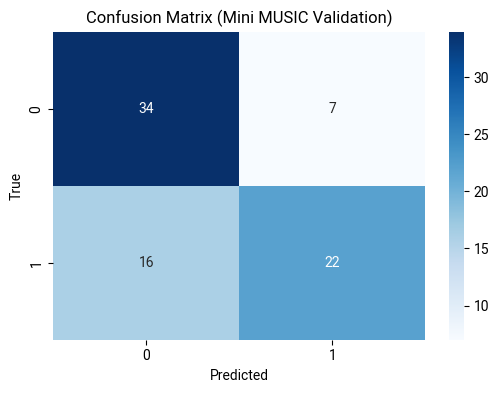

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_mini_music, y_classes_mini_music)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Mini MUSIC Validation)")
save_path = f"{output_path}mini_music_confusion_matrix.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()